<h1 id="tocheading">Attrition Demo</h1>
<div id="toc"></div>

<img src="https://github.com/elenalowery/DSX_Local_Workshop/blob/master/img/CC_Intro.JPG?raw=true" width="800" height="500" align="middle"/>

The Attrition demo focuses on retaining Merchants that are using company network for credit card processing. Here is the description of the case:

A client approved many low value merchant accounts without much scrutiny.  Many of those merchant accounts resulted in default. The client thinks that they should have put more of an emphasis on their applicant screening process. IBM suggests to enable fact based decision making for performance of its joint marketing programs.

This notebook will demostrate how to

1. Use Brunel and Seaborn library for visualizations

2. Use regular python Machine Learning libary scikit-learn and Spark's Machine Learning library(MLlib) for predicitive modeling in an intergrated environment on DSX.
3. Deploy SparkML model using Machine Learning Service

## Set up environment

In [13]:
!pip install seaborn

In [14]:
import sklearn

import pandas as pd
pd.options.display.max_columns = 999

import brunel

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency,ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score

import numpy as np

import urllib3, requests, json

## Load Customer History Data

In [15]:
# The code was removed by Watson Studio for sharing.

,MERCHANT,ACCT_STATUS_K_USD,CONTRACT_DURATION_MONTH,HISTORY,CREDIT_PROGRAM,AMOUNT_K_USD,ACCOUNT_TYPE,ACCT_AGE,STATE,PRESENT_RESIDENT,ESTABLISHED_MONTH,NUMBER_CREDITS,IS_DEFAULT
0,893,0 USD,12,CRITICAL ACCOUNT,NEW CAR,2171,up to 100 K USD,1 to 4 YRS,NY,4,38,2,No
1,894,0 to 200 USD,36,CRITICAL ACCOUNT,USED CAR,5800,up to 100 K USD,1 to 4 YRS,CT,4,34,2,No
2,895,NONE,18,CRITICAL ACCOUNT,ELECTRONICS,1169,UNKNOWN/NONE,1 to 4 YRS,NY,above 4 YRS,29,2,No
3,896,NONE,36,DELAY IN PAST,USED CAR,8947,UNKNOWN/NONE,4 to 7 YRS,CT,2 to 3 YRS,31,1,No
4,897,0 USD,21,EXISTING CREDITS PAID BACK,ELECTRONICS,2606,up to 100 K USD,up to 1 YR,NY,4,28,1,No


### Dataset Overview

Let's take a quick look at the dataset.

In [16]:
print("There are " + str(len(cust_pd)) + " observations in the customer history dataset.")
print("There are " + str(len(cust_pd.columns)) + " variables in the dataset.")

print("******************Descriptive statistics*****************************")
print(cust_pd.describe())

print("\n******************Dataset Quick View*****************************\n")
cust_pd.head()

There are 1000 observations in the customer history dataset.
There are 13 variables in the dataset.
******************Descriptive statistics*****************************
          MERCHANT  CONTRACT_DURATION_MONTH  AMOUNT_K_USD  ESTABLISHED_MONTH  \
count  1000.000000              1000.000000   1000.000000        1000.000000   
mean    500.500000                20.903000   3271.258000          35.546000   
std     288.819436                12.058814   2822.736876          11.375469   
min       1.000000                 4.000000    250.000000          19.000000   
25%     250.750000                12.000000   1365.500000          27.000000   
50%     500.500000                18.000000   2319.500000          33.000000   
75%     750.250000                24.000000   3972.250000          42.000000   
max    1000.000000                72.000000  18424.000000          75.000000   

       NUMBER_CREDITS  
count     1000.000000  
mean         1.407000  
std          0.577654  
min          

,MERCHANT,ACCT_STATUS_K_USD,CONTRACT_DURATION_MONTH,HISTORY,CREDIT_PROGRAM,AMOUNT_K_USD,ACCOUNT_TYPE,ACCT_AGE,STATE,PRESENT_RESIDENT,ESTABLISHED_MONTH,NUMBER_CREDITS,IS_DEFAULT
0,893,0 USD,12,CRITICAL ACCOUNT,NEW CAR,2171,up to 100 K USD,1 to 4 YRS,NY,4,38,2,No
1,894,0 to 200 USD,36,CRITICAL ACCOUNT,USED CAR,5800,up to 100 K USD,1 to 4 YRS,CT,4,34,2,No
2,895,NONE,18,CRITICAL ACCOUNT,ELECTRONICS,1169,UNKNOWN/NONE,1 to 4 YRS,NY,above 4 YRS,29,2,No
3,896,NONE,36,DELAY IN PAST,USED CAR,8947,UNKNOWN/NONE,4 to 7 YRS,CT,2 to 3 YRS,31,1,No
4,897,0 USD,21,EXISTING CREDITS PAID BACK,ELECTRONICS,2606,up to 100 K USD,up to 1 YR,NY,4,28,1,No


## Exploratory Data Analysis

In this section, we will explore the dataset further with some visualizations.

Two open source libraries are used:
* <a href="https://github.com/Brunel-Visualization/Brunel">Brunel</a> is a high-level language that describes visualizations in terms of composable actions. It drives a visualization engine (D3) that performs the actual rendering and interactivity. Brunel makes it much easier to build fun and inventive visualizations in Jupyter notebooks.

* <a href="https://seaborn.pydata.org/">Seaborn</a> is a Python visualization library based on matplotlib. It provides a high-level interface for drawing attractive statistical graphics.

### Outcome Variable: Account Default

In [17]:
%brunel data('cust_pd') x(IS_DEFAULT) y(#count) color(IS_DEFAULT) bar tooltip(#all)

<IPython.core.display.Javascript object>

As you can see from the bar chart, 300 out of 1000 accounts are in default.

### Default by Credit Program

In [18]:
%brunel data('cust_pd') polar stack bar y(#count) color(CREDIT_PROGRAM) percent(#count) tooltip(#all) | stack bar x(CREDIT_PROGRAM) y(#count) color(IS_DEFAULT) bin(CREDIT_PROGRAM) percent(#count) label(#count) tooltip(#all) :: width=1200, height=350 

<IPython.core.display.Javascript object>

* Top 3 credit programs with most Merchants are Electronics(28%), New Car(23.4%) and Furniture(18.1%).
* Top 3 credit programs with high default rate are Education(44%), New Car(38%), and Retraining(35.1%)

### HISTORY vs. IS_DEFAULT

In [19]:
%brunel data('cust_pd') bar x(HISTORY) y(#count) color(HISTORY) tooltip(#all) | stack bar x(HISTORY) y(#count) color(IS_DEFAULT: green-red) bin(HISTORY) sort(HISTORY) percent(#count) label(#count) tooltip(#all) :: width=1200, height=350 

<IPython.core.display.Javascript object>

### AMOUNT_K_USD vs. IS_DEFAULT

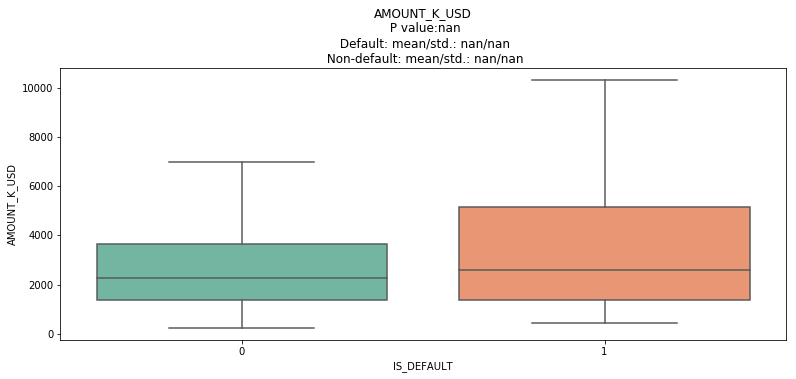

In [33]:
sub_yes = cust_pd[cust_pd["IS_DEFAULT"] == "Yes"]
sub_no = cust_pd[cust_pd["IS_DEFAULT"] == "No"]
    
p_value = ttest_ind(sub_yes['AMOUNT_K_USD'], sub_no["AMOUNT_K_USD"], equal_var = False)[1]

fig, axs = plt.subplots(nrows= 1, figsize=(13, 5))
sns.boxplot(x = "IS_DEFAULT", y = "AMOUNT_K_USD", data = cust_pd, showfliers=False, palette="Set2")
if p_value < .05:
    plt.title("AMOUNT_K_USD" + "\n P value:" + str(p_value) + "\n The distributions for the two groups are significantly different!" + "\n Default: mean/std.: " + str(sub_yes["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_yes["AMOUNT_K_USD"].describe()[2]) + "\n Non-default: mean/std.: " + str(sub_no["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_no["AMOUNT_K_USD"].describe()[2]))
else:
    plt.title("AMOUNT_K_USD" + "\n P value:" + str(p_value) + "\n Default: mean/std.: " + str(sub_yes["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_yes["AMOUNT_K_USD"].describe()[2]) + "\n Non-default: mean/std.: " + str(sub_no["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_no["AMOUNT_K_USD"].describe()[2]))           

In this box plot, the visualization is enhanced by T-test statistics. The result is significant which indicates that the average credit amount for the non-default group and default group are different. Default group has larger average credit amount.



### Default rate by state

In [40]:
default_rate = pd.crosstab(cust_pd.IS_DEFAULT, cust_pd.STATE).apply(lambda r: r/r.sum(), axis=0)

default_rate2 = default_rate.T

%brunel data('default_rate2') map color(state:[reds, blues]) key(STATE) label(STATE)


<IPython.core.display.Javascript object>

Brunel also provides a very neat way for map visualization. So for this use case, all the Merchants come from 4 states: NY, NJ, PA and CT.

### Correlation Matrix

A heatmap is used to visualize the correlations between all continuous variables.

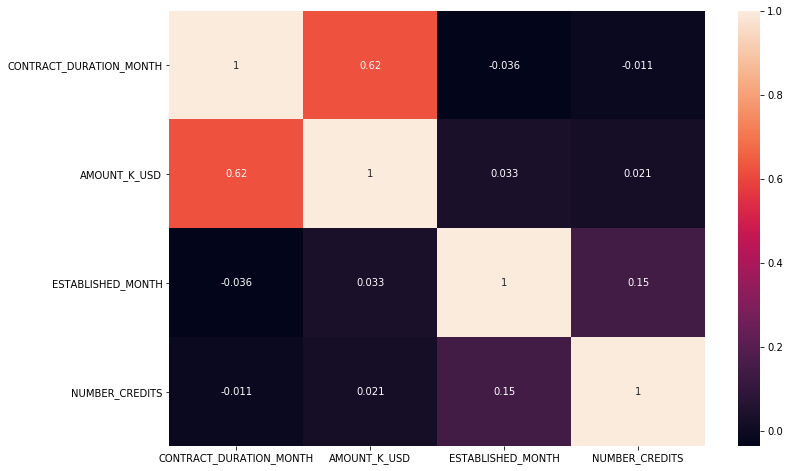

In [22]:
plt.figure(figsize=(12, 8))

corr_df = cust_pd.iloc[:,1:].corr()

sns.heatmap(corr_df, 
            xticklabels = corr_df.columns.values,
            yticklabels = corr_df.columns.values,
            annot = True);


* There is no strong correlation between most variables.
* The correlation between AMOUNT_K_USD and CONTRACT_DURATION_MONTH is moderate.

## Modeling And Evaluation

### Sklearn Random Forest

In [23]:
# convert IS_DEFAULT to 1/0
le = LabelEncoder()

cust_pd.loc[:,'IS_DEFAULT']= le.fit_transform(cust_pd.loc[:,'IS_DEFAULT'])

#y = np.float32(cust_pd.IS_DEFAULT)
y = cust_pd.IS_DEFAULT

# drop y and merchant
X = cust_pd.drop(['IS_DEFAULT', 'MERCHANT'], axis = 1)


In [25]:
!pip install sklearn-pandas

In [26]:
from sklearn_pandas import DataFrameMapper

mapper = DataFrameMapper(
    [('ACCT_STATUS_K_USD', LabelEncoder()),
     ('CONTRACT_DURATION_MONTH', None),
     ('HISTORY',LabelEncoder()),
     ('CREDIT_PROGRAM', LabelEncoder()),
     ('AMOUNT_K_USD',None),
     ('ACCOUNT_TYPE',LabelEncoder()),
     ('ACCT_AGE',LabelEncoder()),
     ('STATE',LabelEncoder()),
     ('PRESENT_RESIDENT',LabelEncoder()),
     ('ESTABLISHED_MONTH',None),
     ('NUMBER_CREDITS',None)]
)

In [27]:
# split the data to training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [28]:
import sklearn.pipeline
from sklearn.preprocessing import OneHotEncoder

random_forest = RandomForestClassifier()
steps = [('mapper', mapper),('RandonForestClassifier', random_forest)]
pipeline = sklearn.pipeline.Pipeline(steps)
model=pipeline.fit( X_train, y_train )
model

Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[('ACCT_STATUS_K_USD', LabelEncoder()), ('CONTRACT_DURATION_MONTH', None), ('HISTORY', LabelEncoder()), ('CREDIT_PROGRAM', LabelEncoder()), ('AMOUNT_K_USD', None), ('ACCOUNT_TYPE', LabelEncoder()), ('ACCT_AGE', LabelEnco...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [29]:
### call pipeline.predict() on your X_test data to make a set of test predictions
y_prediction = pipeline.predict( X_test )
### test your predictions using sklearn.classification_report()
report = sklearn.metrics.classification_report( y_test, y_prediction )
### and print the report
print(report)

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       140
           1       0.50      0.37      0.42        60

   micro avg       0.70      0.70      0.70       200
   macro avg       0.63      0.60      0.61       200
weighted avg       0.68      0.70      0.69       200

